In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

from matplotlib import pyplot as plt

!pip -q install tensorflow_datasets
import tensorflow_datasets as tfds

!pip -q install tensorflow_addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [2]:
BATCH_SIZE= 32
AUTOTUNE= tf.data.experimental.AUTOTUNE

In [3]:
(ds_train, ds_test), ds_info= tfds.load(
    'mnist',
    split= ['train', 'test'],
    shuffle_files= True,
    as_supervised= True,
    with_info= True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


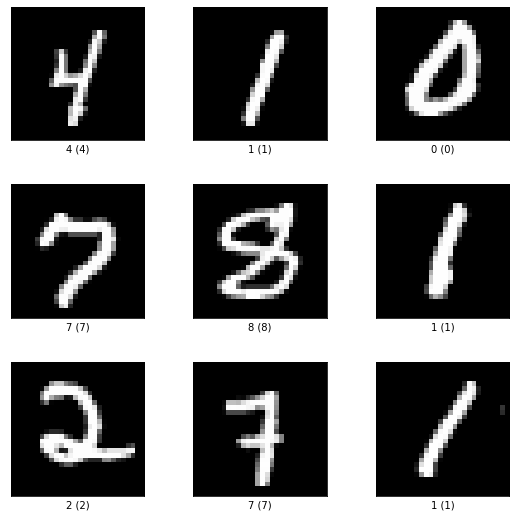

In [4]:
_= tfds.show_examples(ds_train, ds_info, rows=3, cols=3)

In [5]:
# Question THIS
def norm_and_aug(img, label, aug=True):
    img/= 255

    if aug and tf.random.uniform((), minval=0, maxval=5, dtype=tf.int32)<1:
        img= tfa.image.rotate(img, tf.cast(tf.random.uniform((), minval=-50, maxval=50, dtype=tf.int32)/100, tf.float32), fill_mode='constant')

    return img, label

In [6]:
ds_train= ds_train.map(norm_and_aug).cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_test= ds_test.map(lambda x, y: norm_and_aug(x, y, False)).cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [7]:
model= keras.Sequential([
    keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(10, activation='softmax')
])

In [8]:
acc_metric= keras.metrics.SparseCategoricalAccuracy()
loss_fn= keras.losses.SparseCategoricalCrossentropy()
optimizer= keras.optimizers.Adam(0.001)

image_writer = tf.summary.create_file_writer("logs_5/vis_1/")

## Display and save images/figure on tensorboard

In [14]:
with image_writer.as_default():
  images = next(iter(ds_train))
  tf.summary.image("25 training data examples", images[0], max_outputs=25, step=0)


In [48]:
# %load_ext tensorboard
# %tensorboard --logdir=/content/logs_5

## Display with more flexibility

In [38]:
import io
import sklearn.metrics
from tensorboard.plugins import projector
import cv2
import os
import shutil

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""

    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format="png")

    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)

    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)

    # Add the batch dimension
    image = tf.expand_dims(image, 0)

    return image

def image_grid(data, labels, class_names):
    # Data should be in (BATCH_SIZE, H, W, C)
    assert data.ndim == 4

    figure = plt.figure(figsize=(10, 10))
    num_images = data.shape[0]
    size = int(np.ceil(np.sqrt(num_images)))

    for i in range(data.shape[0]):
        plt.subplot(size, size, i + 1, title=class_names[labels[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # if grayscale
        if data.shape[3] == 1:
            plt.imshow(tf.tile(data[i], [1, 1, 3]))
        else:
            plt.imshow(data[i])

    return figure

In [40]:
image_writer = tf.summary.create_file_writer("logs_5/vis_2/")

In [42]:
num_epochs= 10
step= 0
labels= [str(i) for i in range(10)]

for epoch in range(num_epochs):
    for batch_idx, (x, y) in enumerate(ds_train):

        if epoch==0:
            figure = image_grid(x, y, labels)

            with image_writer.as_default():
                tf.summary.image(
                    "Visualize Images", plot_to_image(figure), step=step,
                )

                step += 1

In [46]:
# %reload_ext tensorboard
# %tensorboard --logdir=/content/logs_5